# <span style="color:red">**House Prices - Advanced Regression Techniques**</span>
#### <span style="color:red">**Predict sales prices and practice feature engineering, RFs, and gradient boosting**</span>

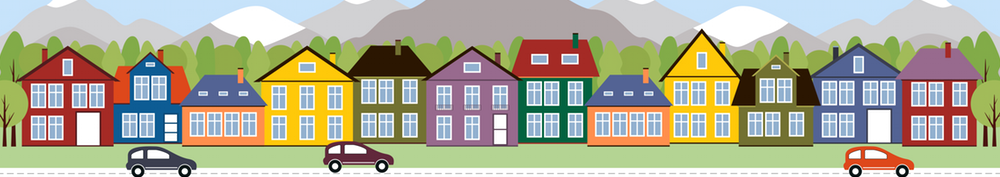

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

### Load Data

In [2]:
df = pd.read_csv('data/train.csv') 

In [3]:
df.shape

(1460, 81)

## Looking into the data
#### Neighborhood

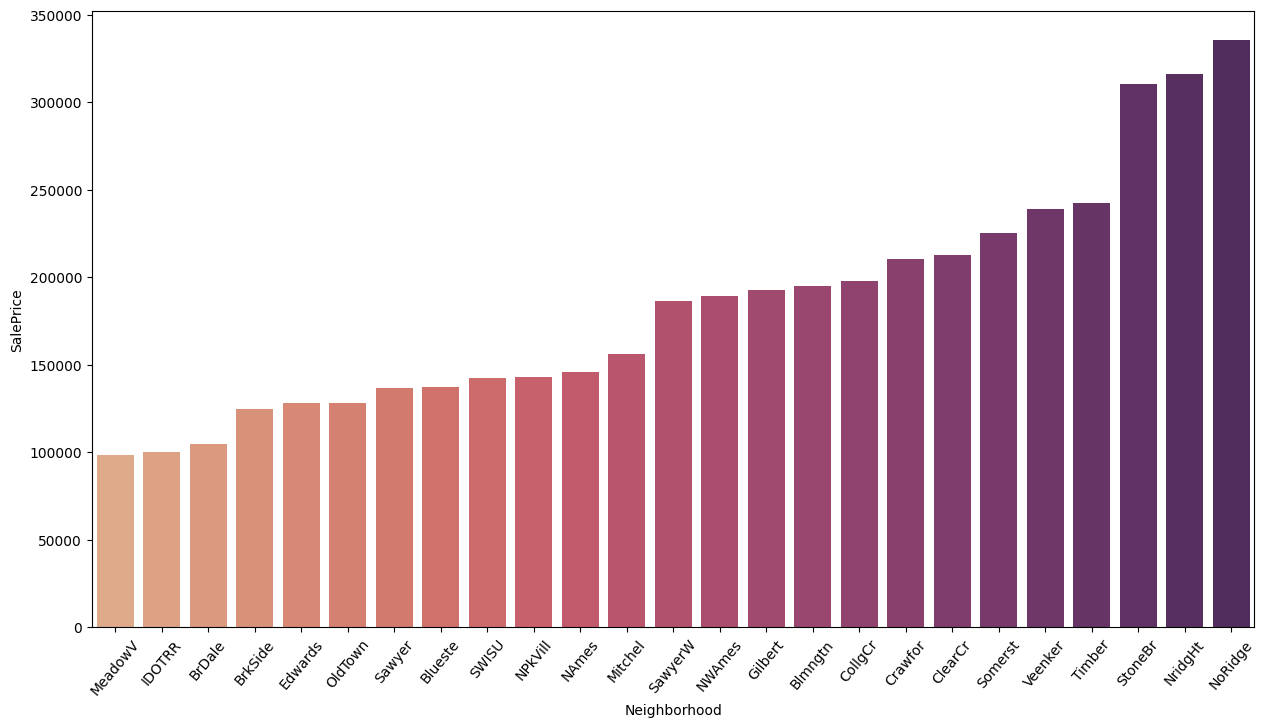

In [4]:
tbp = df.groupby(by='Neighborhood')['SalePrice'].mean().sort_values().reset_index()

plt.figure(figsize=(15,8))
sns.barplot(data=tbp, x='Neighborhood', y= 'SalePrice', palette='flare')
plt.xticks(rotation=50);

Calculating the mean SalePrice for every Neighborhood results in a powerful feature with a price corrlation of ~0.74

In [5]:
Neighborhood = df.groupby(by='Neighborhood')['SalePrice'].mean()
N_dict = dict(zip(Neighborhood.index, Neighborhood))
df['Neighborhood'].replace(N_dict, inplace=True)

pearson = (np.corrcoef(df['Neighborhood'], df['SalePrice']))[1][0]
print(f'Pearson Correlation Coefficient of Neighborhood: {pearson:.3f}')

Pearson Correlation Coefficient of Neighborhood: 0.739


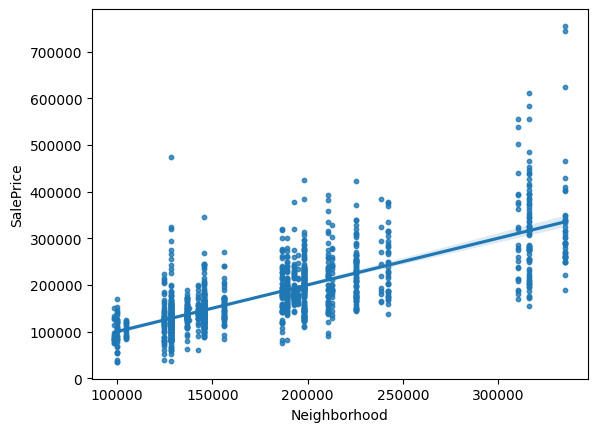

In [6]:
sns.regplot(x = df.Neighborhood, y= df.SalePrice,  scatter_kws={'s':10});

### Outliers

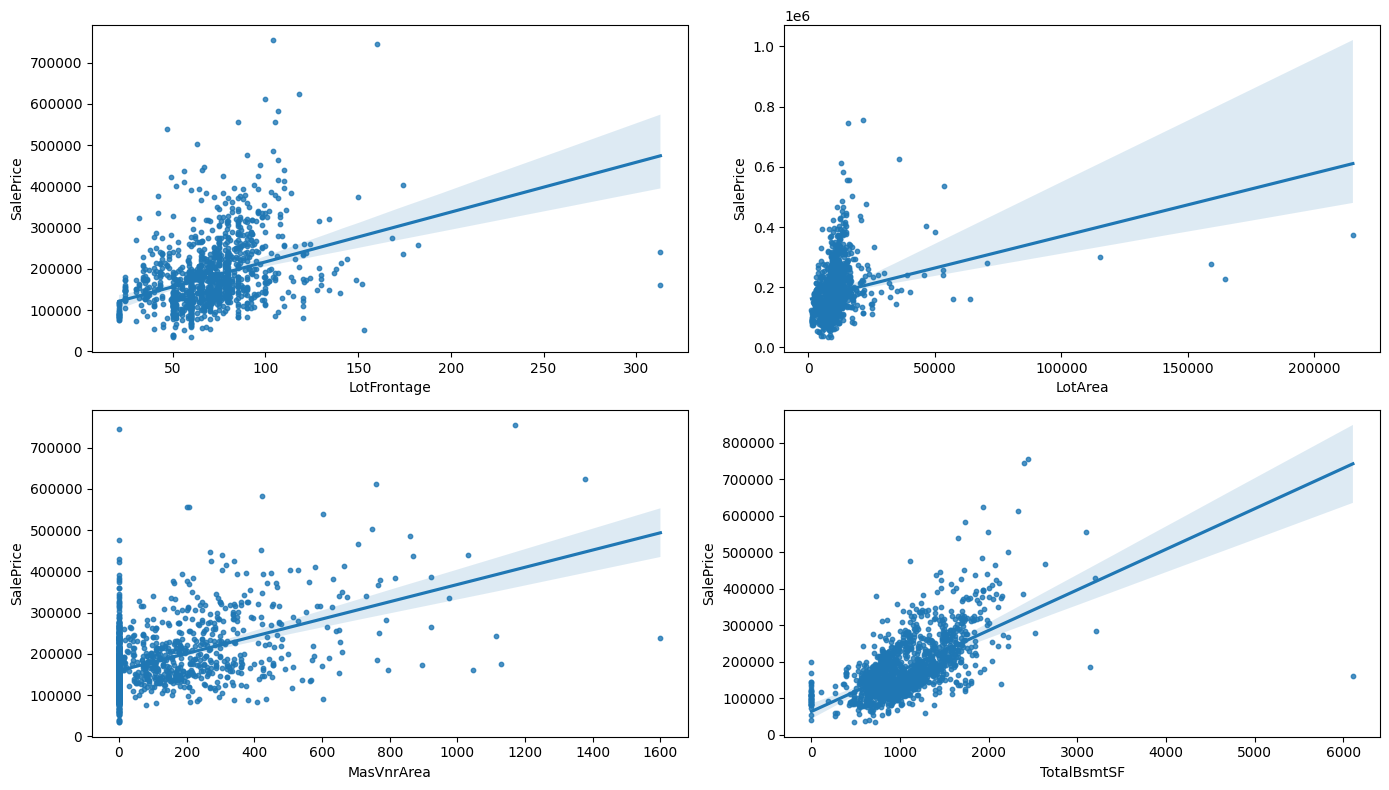

In [7]:
selected_features = ['LotFrontage','LotArea','MasVnrArea','TotalBsmtSF']

fig,ax = plt.subplots(2,2, figsize = (14,8))
for i in range(len(selected_features)):
    sns.regplot(x = df[selected_features[i]], y= df.SalePrice, ax=ax[i//2, i%2], scatter_kws={'s':10})
    
plt.tight_layout()
plt.show()

removal of some outliers manualy

In [8]:
def remove_outlier(df):
    df = df.drop(df[(df['LotFrontage'] > 200)].index)
    df = df.drop(df[(df['LotArea'] > 100000)].index)
    df = df.drop(df[(df['MasVnrArea'] >1500)].index)
    df = df.drop(df[(df['SalePrice'] > 600000)].index)
    df = df.drop(df[(df['TotalBsmtSF'] > 5000)].index)
    return df
df = remove_outlier(df)

## Feature engineering

In [9]:
df['TotalSF']= df['1stFlrSF'] + df['2ndFlrSF'] + df['BsmtFinSF2'] + df['BsmtFinSF1']
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df['TotalporchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
df['YearBaR'] = df['YearBuilt'] + df['YearRemodAdd']


The combined sq. footage 'TotalSF' has a higher price correlation then each single feature by itself. By deleting ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF2' 'BsmtFinSF1'] the dimensionality of the dataframe is reduced by 3.

In [10]:
for i in ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalSF']:
    pearson = (np.corrcoef(df[i], df['SalePrice']))[1][0]
    if i == 'TotalSF':
        print('-'*15)
    print(f'Pearson Correlation Coefficient of {i}: {pearson:.3f}')

Pearson Correlation Coefficient of 1stFlrSF: 0.614
Pearson Correlation Coefficient of 2ndFlrSF: 0.297
Pearson Correlation Coefficient of BsmtFinSF2: -0.015
Pearson Correlation Coefficient of BsmtFinSF1: 0.377
---------------
Pearson Correlation Coefficient of TotalSF: 0.726


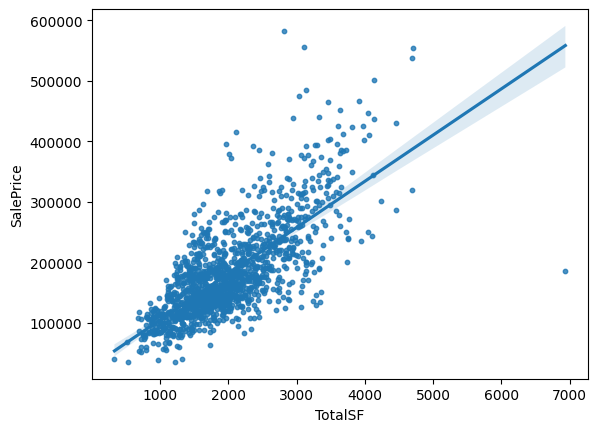

In [11]:
sns.regplot(x = df.TotalSF, y= df.SalePrice,  scatter_kws={'s':10});

The same applies for 'TotalBath'

In [12]:
for i in ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBath']:
    pearson = (np.corrcoef(df[i], df['SalePrice']))[1][0]
    if i == 'TotalBath':
        print('-'*15)
    print(f'Pearson Correlation Coefficient of {i}: {pearson:.3f}')

Pearson Correlation Coefficient of BsmtFullBath: 0.228
Pearson Correlation Coefficient of BsmtHalfBath: -0.039
Pearson Correlation Coefficient of FullBath: 0.557
Pearson Correlation Coefficient of HalfBath: 0.285
---------------
Pearson Correlation Coefficient of TotalBath: 0.631


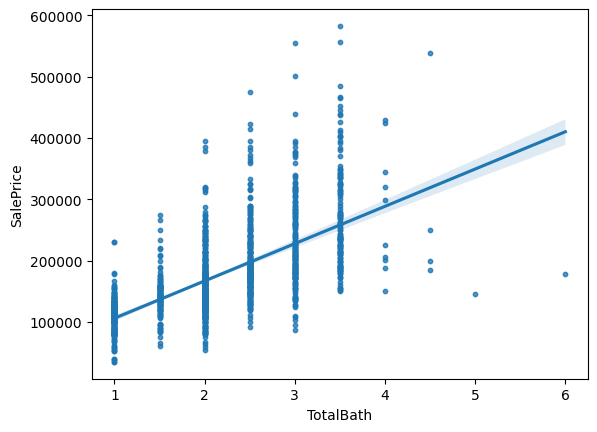

In [13]:
sns.regplot(x = df.TotalBath, y= df.SalePrice,  scatter_kws={'s':10});

Same again. Dimensionality reduced by 4

In [14]:
for i in ['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF', 'TotalporchSF']:
    pearson = (np.corrcoef(df[i], df['SalePrice']))[1][0]
    if i == 'TotalporchSF':
        print('-'*15)
    print(f'Pearson Correlation Coefficient of {i}: {pearson:.3f}')

Pearson Correlation Coefficient of OpenPorchSF: 0.335
Pearson Correlation Coefficient of 3SsnPorch: 0.050
Pearson Correlation Coefficient of EnclosedPorch: -0.129
Pearson Correlation Coefficient of ScreenPorch: 0.124
Pearson Correlation Coefficient of WoodDeckSF: 0.328
---------------
Pearson Correlation Coefficient of TotalporchSF: 0.406


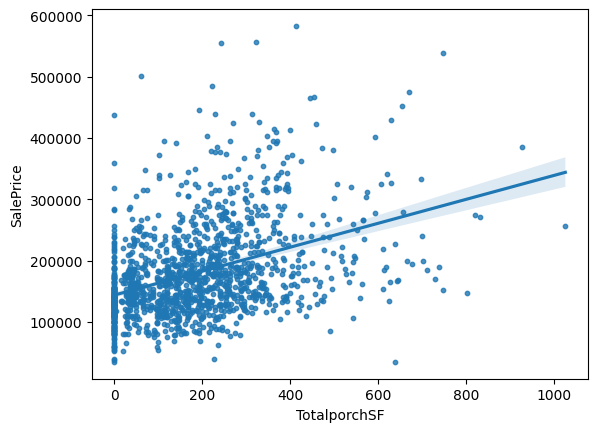

In [15]:
sns.regplot(x = df.TotalporchSF, y= df.SalePrice,  scatter_kws={'s':10});

only a slight improvment here

In [16]:
for i in ['YearBuilt', 'YearRemodAdd', 'YearBaR']:
    pearson = (np.corrcoef(df[i], df['SalePrice']))[1][0]
    if i == 'YearBaR':
        print('-'*15)
    print(f'Pearson Correlation Coefficient of {i}: {pearson:.3f}')

Pearson Correlation Coefficient of YearBuilt: 0.543
Pearson Correlation Coefficient of YearRemodAdd: 0.529
---------------
Pearson Correlation Coefficient of YearBaR: 0.599


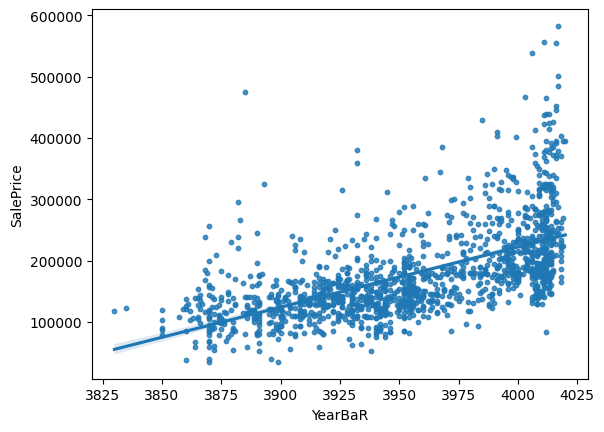

In [17]:
sns.regplot(x = df.YearBaR, y= df.SalePrice,  scatter_kws={'s':10});

### Removal of Features

In [18]:
df.drop(columns=['MoSold', 'YrSold',  'Utilities', 'GarageYrBlt','1stFlrSF', '2ndFlrSF', 
                'BsmtFinSF2', 'BsmtFinSF1', 'Id', 'BsmtFullBath', 'YearRemodAdd', 'YearBuilt',
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 
                'ScreenPorch', 'WoodDeckSF'], inplace=True)

splitting the data

In [19]:
X = df.drop(columns='SalePrice')
y = np.log(df.SalePrice)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=422442)

creating a list for ordinal encoding

In [20]:
cat_ls = ['N_A', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
cat = [cat_ls for _ in range(8)]
cat = cat + [['N_A', 'No', 'Mn', 'Av', 'Gd'],                           # BsmtExposure
             ['N_A', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],         # BsmtFinType1
             ['N_A', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],         # BsmtFinType2
             ['N_A', 'Unf', 'RFn', 'Fin']]                              # GarageFinish

creating the preprocessor

In [21]:
# list of features for ordinal encoding 
X_ord_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                  'HeatingQC', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish']

X_cat_columns = X.select_dtypes(exclude="number").drop(columns=X_ord_columns,axis=1).copy().columns
X_num_columns = X.select_dtypes(include="number").copy().columns

numeric_pipe = make_pipeline(
    KNNImputer()
)

categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore')    
)

ordinal_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OrdinalEncoder(categories=cat)    
)   

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns),
        ('ord_pipe', ordinal_pipe, X_ord_columns)
    ]
)

final shape of the data

In [22]:
preprocessor.fit_transform(X).shape

(1449, 211)

creating the final pipeline with stacking of different Regressors

In [23]:
rand = 422442
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=5))
lasso = make_pipeline(RobustScaler(),LassoCV(max_iter=3000, random_state=rand, cv=5))
knr = make_pipeline(RobustScaler(),KNeighborsRegressor())

rf = RandomForestRegressor(random_state=rand)
gbr = GradientBoostingRegressor(n_estimators=300, max_features='sqrt', random_state =rand)
xgbr = XGBRegressor(learning_rate=0.02, n_estimators=2000)

In [24]:
stack = make_pipeline(preprocessor, StackingCVRegressor(regressors=(ridge, lasso, knr, gbr, rf),
                                                                meta_regressor=xgbr,
                                                                use_features_in_secondary=True,
                                                                random_state=rand))

fitting the data

In [25]:
stack.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars'...
                                                 Pipeline(steps=[('robustscaler',
                                                                  RobustScaler()),
                                                                 ('lassocv',
                                                                  LassoCV(cv=5,
                                                                          max_iter=3000,
                                                                          random_state=422442))]),
                                                 Pipeline(steps=[('robustscaler',
                                                                  RobustScaler()),
                                                                 ('kneighborsregressor',
                                                                  KNeighborsRegressor())]),
                                                 GradientBoostingRegressor(max_features='sqrt',
                                                                           n_estimators=300,
                                                                           random_state=422442),
                                                 RandomForestRegressor(random_state=422442)),
                                     use_features_in_secondary=True))])

#### Make predictions

In [26]:
y_train_pred = np.exp(stack.predict(X_train))
y_test_pred = np.exp(stack.predict(X_test))
y_train = np.exp(y_train)
y_test = np.exp(y_test)

In [33]:
y_train_pred.ndim

1

# Evaluation of the model

In [27]:
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmsl = mean_squared_log_error(y_train, y_train_pred, squared=False)
test_rmsl = mean_squared_log_error(y_test, y_test_pred, squared=False)

print(f'Model Train RMSE: {train_rmse:.2f}')
print(f'Model Test RMSE : {test_rmse:.2f}\n')
print(f'Model Train r2: {train_r2:.2f}')
print(f'Model Test r2 : {test_r2:.2f}\n')
print(f'Model Train RSML: {train_rmsl:.2f}')
print(f'Model Test RSML : {test_rmsl:.2f}\n')

Model Train RMSE: 5551.19
Model Test RMSE : 5589.66

Model Train r2: 0.99
Model Test r2 : 0.99

Model Train RSML: 0.03
Model Test RSML : 0.03



In [399]:
def mean_abs_perc_error(y_true, y_pred):
    results = pd.DataFrame({
        'predictions':y_pred,
        'true_values':y_true
    })
mod_res = {}


        MSE: 31244251.73408192
        RMSE: 5589.655779570145
        MAE: 3923.6411233836197
        MAPE: None
        
528386.1875 61044.3984375


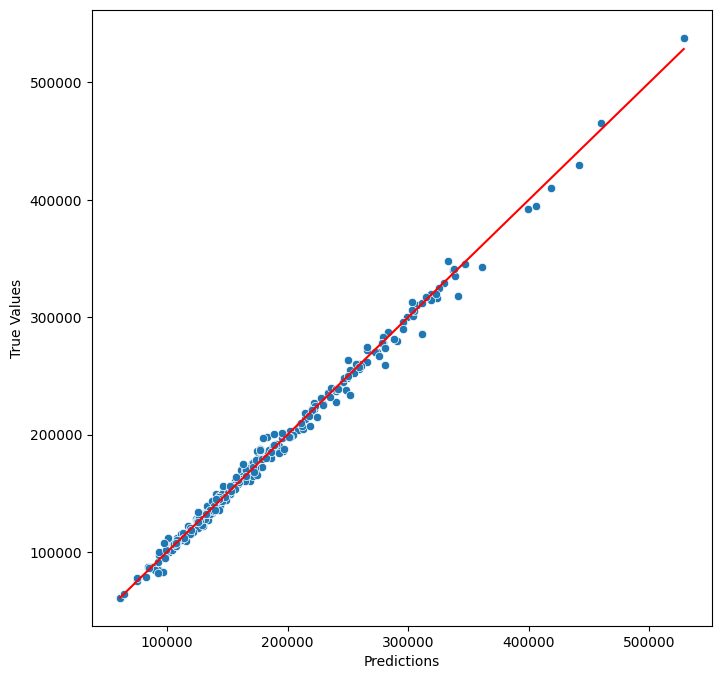

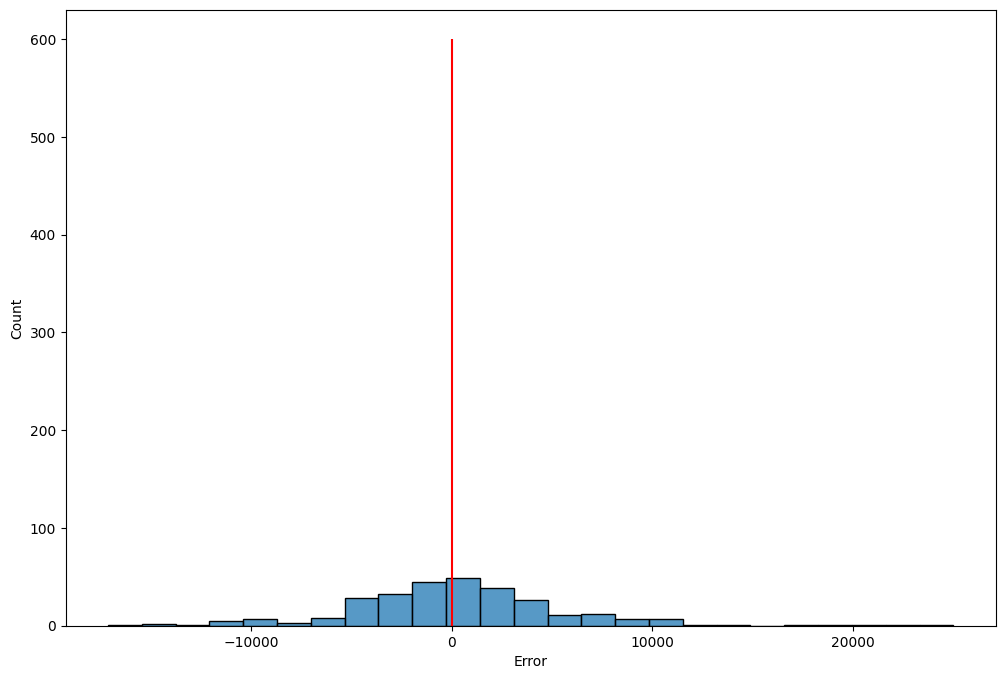

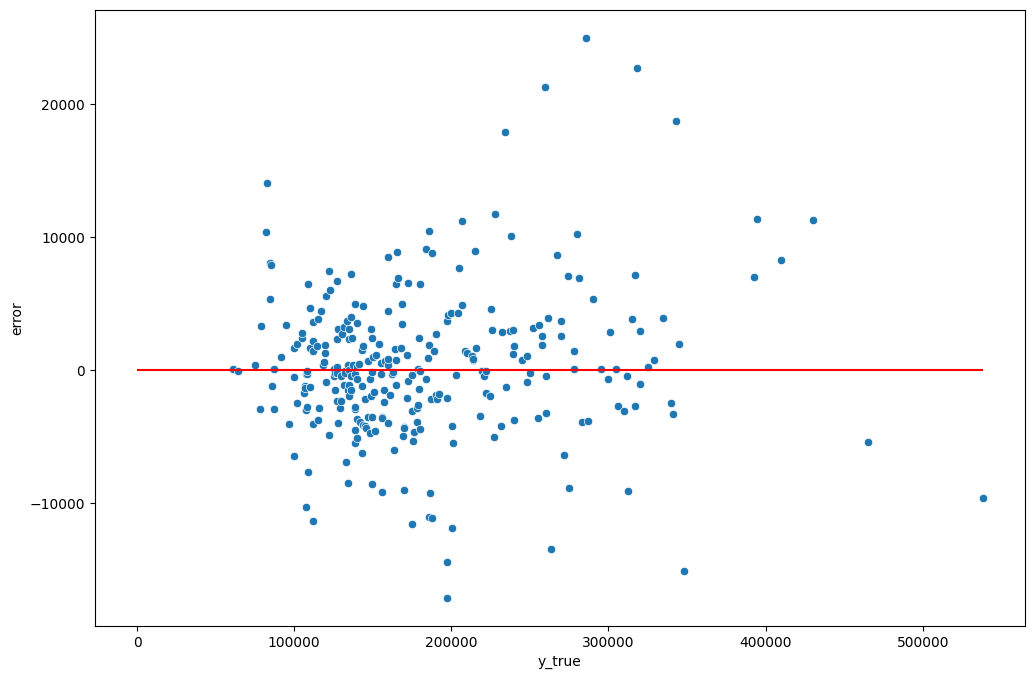

In [401]:
def plot_predictions(y_true, y_pred):
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        MAPE: {mean_abs_perc_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('True Values')
    plt.xlabel('Predictions')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    errors = y_pred - y_true
    plt.subplots(figsize=(12, 8))
    sns.histplot(errors)
    plt.xlabel('Error')
    plt.vlines(x=0, ymin=0, ymax=600, color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by='y_true')
        )

    plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=p_df, x='y_true', y='error')
    plt.hlines(y=0, xmin=0, xmax=max(p_df['y_true']), color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    return {
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred)**0.5,
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_abs_perc_error(y_true, y_pred)

    }




mod_res['2nd_iter'] = plot_predictions(y_train, y_train_pred)